In [560]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, make_scorer, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing, metrics


In [419]:
# pickle ファイルから読み込み
train_pkl = pd.read_pickle('../001/train.pk1')

In [420]:
train_pkl.shape

(850, 11)

In [421]:
# 年齢(Age)、性別(Gender_Male)は削除
train_pkl.drop(['Gender_Male'], axis=1, inplace=True)

In [422]:
train_pkl.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,0.787109,0.150513,220.178696,13.467617,21.729246,6.816406,3.111328,1.006836,0
1,69,1.003906,0.195679,221.218414,51.033463,64.752319,6.890625,3.050781,0.751465,1
2,65,0.657227,0.081299,320.770538,12.625011,30.613180,5.949219,2.488281,0.774902,0
3,65,0.906738,0.214233,369.278168,34.347599,54.510086,6.968750,3.613281,0.988281,1
4,22,1.735352,0.197754,222.782028,20.572891,170.010178,5.835938,3.068359,1.026367,0


In [423]:
train_pk2 = train_pkl.copy()
train_pkl.shape

(850, 10)

In [424]:
# I_Bill間接ビルビリンを追加
train_pkl['I_Bill'] = train_pkl['T_Bil'] - train_pkl['D_Bil']
# 直接ビルビリンを追加
train_pkl['P_Bill'] = train_pkl['D_Bil'] / train_pkl['T_Bil']


In [425]:
disease_bk = train_pkl.disease.values

In [426]:
train_pkl.drop('disease', axis=1, inplace=True)

In [427]:
train_pkl['disease'] = disease_bk

In [428]:
train_pkl.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,I_Bill,P_Bill,disease
0,59,0.787109,0.150513,220.178696,13.467617,21.729246,6.816406,3.111328,1.006836,0.636719,0.191162,0
1,69,1.003906,0.195679,221.218414,51.033463,64.752319,6.890625,3.050781,0.751465,0.808105,0.194946,1
2,65,0.657227,0.081299,320.770538,12.625011,30.613180,5.949219,2.488281,0.774902,0.576172,0.123718,0
3,65,0.906738,0.214233,369.278168,34.347599,54.510086,6.968750,3.613281,0.988281,0.692383,0.236328,1
4,22,1.735352,0.197754,222.782028,20.572891,170.010178,5.835938,3.068359,1.026367,1.537109,0.113953,0


## 訓練データとテストデータに分割

In [518]:
# 訓練とテストデータに分割
train, test = train_test_split(train_pkl, test_size=0.2, random_state=4242)

In [519]:
# ターゲットと特徴量の分割
train_X = train.iloc[:, :-1]
train_y = train.disease.values

In [520]:
# ターゲットと特徴量の分割
test_x = test.iloc[:, :-1]
test_y = test.disease.values

## 訓練データで訓練

In [573]:
XGB = XGBClassifier(lambda_l1=0, lamba_l2=1, max_depth=7, romdam_stat=4242)
# XGB = XGBClassifier(random_state=4242)

In [574]:
XGB = XGB.fit(train_X, train_y, early_stopping_rounds=20, eval_metric='auc', eval_set=[(test_x, test_y)])

[0]	validation_0-auc:0.888797
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.897798
[2]	validation_0-auc:0.92965
[3]	validation_0-auc:0.924041
[4]	validation_0-auc:0.930758
[5]	validation_0-auc:0.932835
[6]	validation_0-auc:0.937543
[7]	validation_0-auc:0.936297
[8]	validation_0-auc:0.935535
[9]	validation_0-auc:0.93782
[10]	validation_0-auc:0.940105
[11]	validation_0-auc:0.937613
[12]	validation_0-auc:0.93789
[13]	validation_0-auc:0.937336
[14]	validation_0-auc:0.936297
[15]	validation_0-auc:0.93782
[16]	validation_0-auc:0.93782
[17]	validation_0-auc:0.938374
[18]	validation_0-auc:0.939205
[19]	validation_0-auc:0.941836
[20]	validation_0-auc:0.944052
[21]	validation_0-auc:0.943637
[22]	validation_0-auc:0.943637
[23]	validation_0-auc:0.945021
[24]	validation_0-auc:0.945437
[25]	validation_0-auc:0.945575
[26]	validation_0-auc:0.946268
[27]	validation_0-auc:0.948068
[28]	validation_0-auc:0.948345
[29]	validation_0-auc:0.949038
[30]	validation_0-auc

In [575]:
XGB.feature_importances_

array([0.03725437, 0.32679653, 0.08054273, 0.077772  , 0.10102271,
       0.10974928, 0.04837396, 0.03659161, 0.07794213, 0.04785149,
       0.05610317], dtype=float32)

In [576]:
sorted(
    zip(map(lambda x: round(x, 3), XGB.feature_importances_), train_X.iloc[:, :].columns),
    reverse=True)

[(0.327, 'T_Bil'),
 (0.11, 'AST_GOT'),
 (0.101, 'ALT_GPT'),
 (0.081, 'D_Bil'),
 (0.078, 'ALP'),
 (0.078, 'AG_ratio'),
 (0.056, 'P_Bill'),
 (0.048, 'TP'),
 (0.048, 'I_Bill'),
 (0.037, 'Alb'),
 (0.037, 'Age')]

## テストデータで実行

In [582]:
test_x.shape, test_y.shape

((170, 11), (170,))

In [583]:
pred_y = XGB.predict(test_x)

In [584]:
confusion_matrix(test_y, pred_y)

array([[79,  8],
       [12, 71]], dtype=int64)

In [585]:
accuracy_score(test_y, pred_y)

0.8823529411764706

In [586]:
test_y.sum(), pred_y.sum()

(83, 79)

## ROC曲線

In [587]:
roc_auc_score(test_y, pred_y)

0.881733831879241

In [588]:
fpr, tpr, thr = roc_curve(test_y, pred_y)

In [589]:
auc = metrics.auc(fpr, tpr)

In [590]:
auc

0.881733831879241

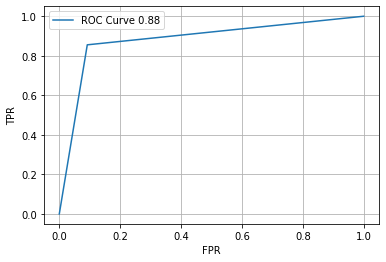

In [591]:
plt.plot(fpr, tpr, label="ROC Curve %.2f"%auc)
plt.legend()
plt.xlabel('FPR')
plt.ylabel("TPR")
plt.grid()
plt.show()

## 学習曲線

In [611]:
XGB2 = XGBClassifier(lambda_l1=300, lamba_l2=300, max_depth=7, romdam_stat=4242)

In [615]:
train_X.shape, test_x.shape

((680, 11), (170, 11))

In [612]:
train_size, train_scores, test_scores = \
learning_curve(estimator=XGB2, X=train_X, y=train_y, 
               train_sizes=np.linspace(0.1, 1.0, 10))

In [613]:
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

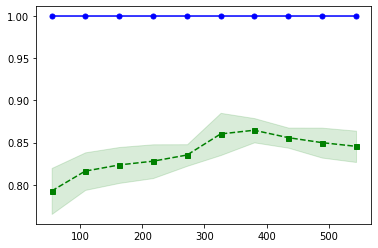

In [614]:
plt.plot(train_size, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.plot(train_size, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_size, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.fill_between(train_size, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')


## 検証データで実行

In [502]:
# 検証データ読み込み
valid = pd.read_pickle('../001/test.pk1')

In [503]:
valid.shape

(350, 10)

In [504]:
type(valid)

pandas.core.frame.DataFrame

In [505]:
# valid_X = valid.iloc[:, 1:]
valid_X = valid.copy()

In [506]:
valid_X.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Male
0,25,0.801758,0.186768,214.448685,15.260516,19.496649,6.816406,3.601562,1.288086,1
1,26,0.834961,0.116455,234.136810,10.509159,16.733311,6.796875,3.111328,1.030273,0
2,64,0.791992,0.197998,216.039902,14.578304,20.695866,7.523438,3.626953,1.278320,1
3,65,0.833984,0.175781,200.901123,12.820356,20.102516,6.828125,3.626953,1.275391,1
4,34,0.690430,0.135498,208.705841,20.279018,25.096685,8.664062,4.171875,1.280273,0


In [507]:
# 年齢、性別は削除
valid_X.drop(['Gender_Male'], axis=1, inplace=True)

In [508]:
valid_X.shape

(350, 9)

In [509]:
# I_Bill間接ビルビリンを追加
valid_X['I_Bill'] = valid_X['T_Bil'] - valid_X['D_Bil']
# 直接ビルビリンを追加
valid_X['P_Bill'] = valid_X['D_Bil'] / valid_X['T_Bil']


In [510]:
valid_X.shape, train_X.shape

((350, 11), (680, 11))

In [511]:
valid_X.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,I_Bill,P_Bill
0,25,0.801758,0.186768,214.448685,15.260516,19.496649,6.816406,3.601562,1.288086,0.615234,0.232910
1,26,0.834961,0.116455,234.136810,10.509159,16.733311,6.796875,3.111328,1.030273,0.718750,0.139526
2,64,0.791992,0.197998,216.039902,14.578304,20.695866,7.523438,3.626953,1.278320,0.593750,0.250000
3,65,0.833984,0.175781,200.901123,12.820356,20.102516,6.828125,3.626953,1.275391,0.658203,0.210815
4,34,0.690430,0.135498,208.705841,20.279018,25.096685,8.664062,4.171875,1.280273,0.554688,0.196289


In [512]:
pred_valid_y = XGB.predict(valid_X)

In [513]:
pred_valid_y.shape

(350,)

In [514]:
# type(valid_pass), type(pred_valid_y)

In [515]:
result_df = pd.DataFrame(pred_valid_y)

In [516]:
result_df.to_csv("./XGB_8.csv", header=False)

In [517]:
pred_valid_y.sum()

139